
---
title: Lab 7 - Mason Brehmer
echo: true
format: 
  html: 
    embed-resources: true
    code-fold: true
    toc: true

---
[View the GitHub Repository](https://github.com/masonbrehmer/GSB_544_Labs/tree/main) 

# Cleaning Data

In [36]:
#pip install scikit-learn

In [37]:
import pandas as pd
import numpy as np


In [38]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [39]:
ha.info()
ha.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


In [40]:
ha.isna().sum()

,0
age,0
sex,0
cp,0
trtbps,0
chol,0
restecg,0
thalach,0
output,0


# Part 1: Fitting Models

In [41]:
# Importing all the potential functions I need from scikit learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix, RocCurveDisplay, roc_curve)
from sklearn.neighbors import KNeighborsRegressor


# Define target and predictors
# I had chat give me what it expected to be the potential five best predictors based on the dataset
# I ran each one and hte best set of predictors based on the ROC AUC was X3
#X = ha.drop(columns=["output"])
#X2 = ha[["age", "sex", "cp", "chol", "thalach", "restecg"]]
X3 = ha[["cp", "thalach", "age", "sex"]]
#X4 = ha[["cp", "thalach"]]
#X5 = ha[["age", "sex", "cp", "trtbps", "restecg", "thalach"]]
#X6 = ha[["trtbps", "chol", "thalach", "restecg"]]
X = X3
y = ha["output"].astype(int)   # make sure target is 0/1 int



In [42]:
# Setting up training and testing data / gemini suggested I put stratify in and then I looked it up and saw that it keeps proportions so I kept it
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=123, stratify=y )


**KNN**

In [43]:
# KNN CT
num_cols = [c for c in X.columns if c in ["age", "trtbps", "chol", "thalach"]]
cat_cols = [c for c in X.columns if c in ["sex", "cp", "restecg"]]


knn_ct = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         cat_cols),

        ("standardize",
         StandardScaler(),
         num_cols)
    ]
)

knn_pipeline_1 = Pipeline(
    [
        ("preprocessing", knn_ct),
        ("knn_classifier", KNeighborsClassifier())
    ]
)

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid_knn = {
    "knn_classifier__n_neighbors": range(1, 50)   # try k = 1 through 50
}


In [45]:
knn_grid = GridSearchCV(
    knn_pipeline_1,
    param_grid=param_grid_knn,
    scoring="roc_auc",
    cv=10
)

knn_grid.fit(X_train, y_train)

print("Best K:", knn_grid.best_params_)
print("Best CV ROC AUC:", knn_grid.best_score_)


Best K: {'knn_classifier__n_neighbors': 38}
Best CV ROC AUC: 0.8575454545454546


In [46]:
best_knn = knn_grid.best_estimator_
best_knn

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['cp', 'sex']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['thalach', 'age'])])),
                ('knn_classifier', KNeighborsClassifier(n_neighbors=38))])

In [47]:
y_pred_knn = best_knn.predict(X_test)
y_pred_knn

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0])

In [48]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm_knn = confusion_matrix(y_test, y_pred_knn)

pd.DataFrame(
    cm_knn,
    index=["True 0", "True 1"],
    columns=["Pred 0", "Pred 1"]
)


,Pred 0,Pred 1
True 0,27,5
True 1,9,28


In [49]:
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]
y_proba_knn

array([0.23684211, 0.18421053, 0.63157895, 0.36842105, 0.13157895,
       0.86842105, 0.13157895, 0.76315789, 0.31578947, 0.39473684,
       0.44736842, 0.55263158, 0.47368421, 0.31578947, 0.15789474,
       0.36842105, 0.60526316, 0.84210526, 0.52631579, 0.68421053,
       0.78947368, 0.07894737, 0.36842105, 0.86842105, 0.47368421,
       0.39473684, 0.78947368, 0.34210526, 0.5       , 0.23684211,
       0.81578947, 0.60526316, 0.76315789, 0.86842105, 0.05263158,
       0.78947368, 0.44736842, 0.81578947, 0.23684211, 0.94736842,
       0.52631579, 0.55263158, 0.13157895, 0.18421053, 0.55263158,
       0.78947368, 0.13157895, 0.21052632, 0.57894737, 0.13157895,
       0.81578947, 0.47368421, 0.65789474, 0.31578947, 0.5       ,
       0.10526316, 0.57894737, 0.31578947, 0.81578947, 0.63157895,
       0.23684211, 0.55263158, 0.76315789, 0.78947368, 0.57894737,
       0.47368421, 0.92105263, 0.13157895, 0.28947368])

**Logistic Regression**



In [50]:
logit_ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
        ("scale", StandardScaler(), num_cols)
    ]
)

# Logistic regression pipeline
logit_pipeline = Pipeline([
    ("preprocessing", logit_ct),
    ("logit", LogisticRegression(max_iter=500))
])

In [51]:
param_grid_logit = {
    "logit__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

logit_grid = GridSearchCV(
    estimator = logit_pipeline,
    param_grid = param_grid_logit,
    cv = 10,
    scoring = "roc_auc"
)

logit_grid.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['cp',
                                                                          'sex']),
                                                                        ('scale',
                                                                         StandardScaler(),
                                                                         ['thalach',
                                                                          'age'])])),
                                       ('logit',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'logit__C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [52]:
print("Best C value:", logit_grid.best_params_)
print("Best CV ROC AUC:", logit_grid.best_score_)

best_logit = logit_grid.best_estimator_


Best C value: {'logit__C': 1}
Best CV ROC AUC: 0.8568484848484849


In [53]:
logit_preds = best_logit.predict(X_test)

cm_logit = confusion_matrix(y_test, logit_preds)
cm_logit


array([[21, 11],
       [ 6, 31]])

**Decision Tree**

In [54]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
        ("scale", StandardScaler(), num_cols)
    ]
)
tree_pipeline = Pipeline([
    ("preprocess", ct),   # the same CT as KNN + logit
    ("tree", DecisionTreeClassifier())
])
param_grid_tree = {
    "tree__max_depth": range(1, 21),
    "tree__min_samples_leaf": [1, 2, 5, 10]
}





In [55]:
grid_tree = GridSearchCV(
    estimator = tree_pipeline,
    param_grid = param_grid_tree,
    cv = 10,
    scoring = "roc_auc"
)
grid_tree.fit(X_train, y_train)
best_tree = grid_tree.best_estimator_

In [56]:
print("Best Tree Hyperparameters:", grid_tree.best_params_)
print("Best CV ROC AUC:", grid_tree.best_score_)

Best Tree Hyperparameters: {'tree__max_depth': 2, 'tree__min_samples_leaf': 1}
Best CV ROC AUC: 0.8188434343434343


In [57]:
tree_preds = best_tree.predict(X_test)
confusion_matrix(y_test, tree_preds)


array([[24,  8],
       [ 9, 28]])

**Interpretation**


The predictors that I believe were most important in predicting heart attack risk were chest pain type, cp, maximum heart rate achieve, age, and sex. As I stated in my comment in the code earlier I tried many different model types across all 3 models, and these four variables used as predictors produced the highest predictive performance in the ROC AUC in all 3 models we created. This shows that they contain the strongest ability for distinguishing between patients that are at risk and are not at risk for having heart attacks. Along with this, our logistic regression coefficients showed that sex as well as cp had positive, strong effects, and age increased risk and thalach reduced risk. Also, the X3 model that used cp, thalach, age, and sex also produced the best confusion-matrix results giving the fewest false negatives and the most true positives, showing it was more effective at correctly identifying patients who had higher risks.

**ROC Curves**

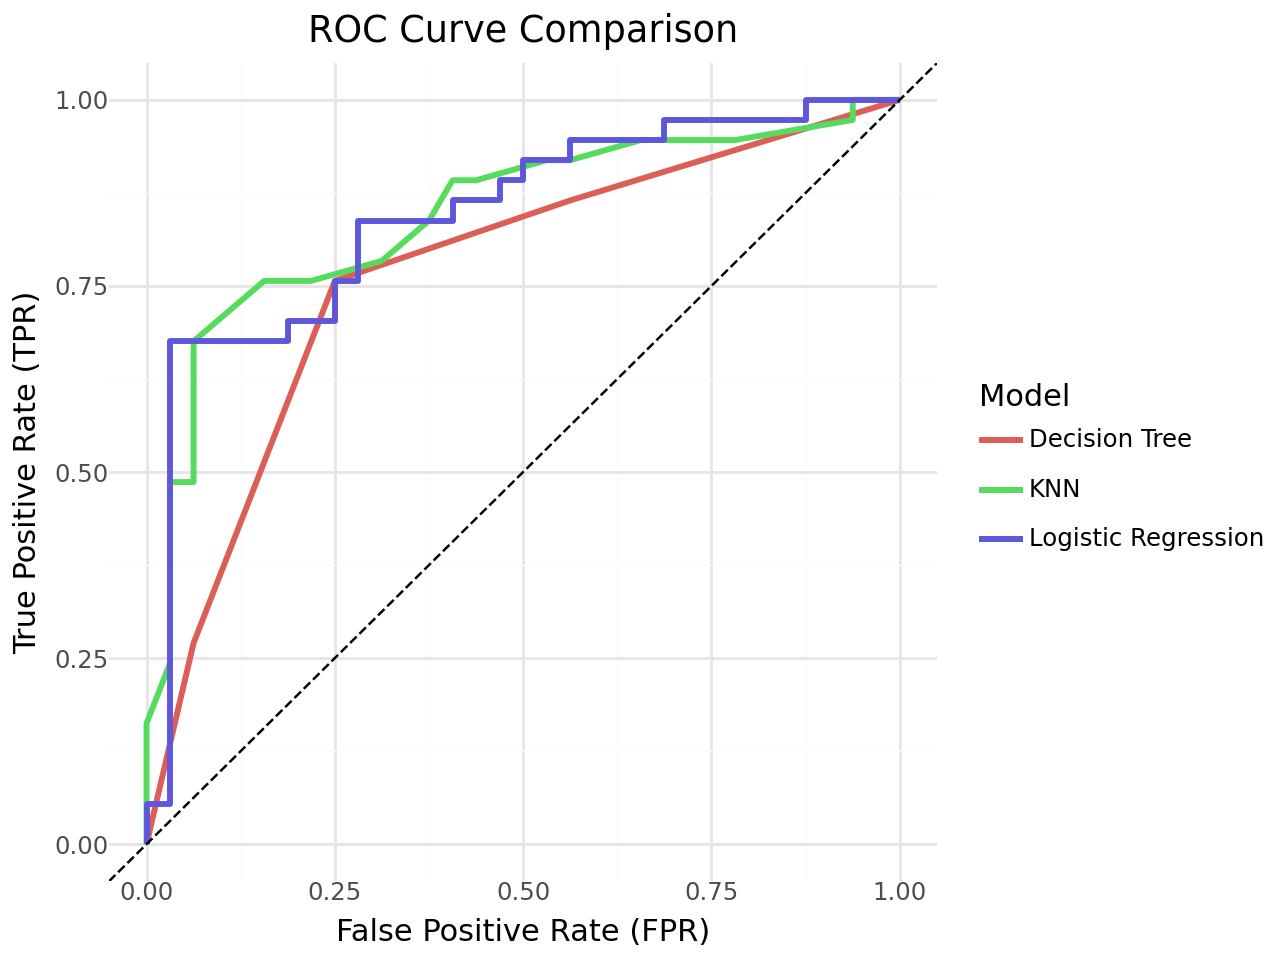

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import plotnine as p9

# Get predicted probabilites for each model
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]
y_proba_logit = best_logit.predict_proba(X_test)[:, 1]
y_proba_tree = best_tree.predict_proba(X_test)[:, 1]

# compute ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_proba_logit)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)


# compute AUC
auc_knn = roc_auc_score(y_test, y_proba_knn)
auc_logit = roc_auc_score(y_test, y_proba_logit)
auc_tree = roc_auc_score(y_test, y_proba_tree)

# Building the dataframe for GGplot
roc_df = pd.DataFrame({
    "FPR": list(fpr_knn) + list(fpr_logit) + list(fpr_tree),
    "TPR": list(tpr_knn) + list(tpr_logit) + list(tpr_tree),
    "Model": (["KNN"]*len(fpr_knn)) +
             (["Logistic Regression"]*len(fpr_logit)) +
             (["Decision Tree"]*len(fpr_tree))
})

# GGplot curve
(
    p9.ggplot(roc_df, p9.aes(x="FPR", y="TPR", color="Model"))
    + p9.geom_line(size=1.2)
    + p9.geom_abline(linetype="dashed")
    + p9.labs(
        title="ROC Curve Comparison",
        x="False Positive Rate (FPR)",
        y="True Positive Rate (TPR)"
    )
    + p9.theme_minimal()
)


# Part Two: Metrics

In [59]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

tn = cm_knn[0,0]
fp = cm_knn[0,1]
fn = cm_knn[1,0]
tp = cm_knn[1,1]

knn_recall = tp / (tp + fn)
knn_precision = tp / (tp + fp)
knn_specificity = tn / (tn + fp)

print(knn_recall, knn_precision, knn_specificity)


0.7567567567567568 0.8484848484848485 0.84375


In [60]:
cm_logit = confusion_matrix(y_test, logit_preds)

tn = cm_logit[0,0]
fp = cm_logit[0,1]
fn = cm_logit[1,0]
tp = cm_logit[1,1]

logit_recall = tp / (tp + fn)
logit_precision = tp / (tp + fp)
logit_specificity = tn / (tn + fp)

print(logit_recall, logit_precision, logit_specificity)


0.8378378378378378 0.7380952380952381 0.65625


In [61]:
cm_tree = confusion_matrix(y_test, tree_preds)

tn = cm_tree[0,0]
fp = cm_tree[0,1]
fn = cm_tree[1,0]
tp = cm_tree[1,1]

tree_recall = tp / (tp + fn)
tree_precision = tp / (tp + fp)
tree_specificity = tn / (tn + fp)

print(tree_recall, tree_precision, tree_specificity)


0.7567567567567568 0.7777777777777778 0.75


# Part 3: Discussion


**Q1**

**The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.**

**Which metric(s) you would use for model selection and why.**

In this case, the biggest concern is about situations where a patient is labeled low risk but then eventually has a heart attack which makes a lot of sense. This type of error is false negative, and that means the metric that measures htis model's ability to avoid it is Recall or Sensitivity. This tells us of every really high-risk patients how mnay were correct.

**Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.**

If we base our recommendation on the model with the best recall value, we would choose the Logistic Regression model as the best opiton. Logistic regression had a sensitivy of .8378 which was much hihger than KNN or DT meaning it misses the fewest high-risk patients. Even though it does not have the best specificty or precision, those aren't the critical metrics in this case.
What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

**What score you should expect for your chosen metric(s) using your chosen model to predict future observations.**

Based on our chosen metric we expect our model to predict about 84% of truly high-risk pateints correctly going forward. This is the strongest sensitivty rate we got out of our three models, however this means based on our data the hospital would still potentially misidentify around 16% of patients which could be dangerous and reason for the hospital to continually find better models.

**Q2**

**The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.**

**Which metric(s) you would use for model selection and why.**

Here, we see the hospital is too crowded and needs to only reserve beds for patients who are most likely to be at risk of the heart attacks. Here we are prioritizing false positives or the cases wher ehte model incorrectly predicts high risk and assings people to beds unnecessarily. The best metric here is Precision which shows us of all patients who are predicted to be high risk how many are actually high risk. With high precision we can ensure that majority of flagged patietns actually need the monitoring and therefore help the hospital whith there goal.

**Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.**

Based on using the precision values, we see that the KNN model is the best for our situation. KNN had a precision value of .8485 which outperformed the logistic and decision tree. This shows that when KNN predicts patients at high risk it is correct about 85% of the time making it the most efficient to reduce unnecessary admissions and limit bedspace.

**What score you should expect for your chosen metric(s) using your chosen model to predict future observations.**


Because the KNN model produced a precision esimate of around 85% that means in practice we expect around 85% of hte patietns flagged as high risk to actually be high risk if the hospital uses the metric for future observations. Although there may be more false negatives, it's acceptable here because the objective is for the hospital to minimize the amount of wasted beds and not the medical risk.


**Q3**


**The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.**


**Which metric(s) you would use for model selection and why.**

In this case, because the hospital wnats to study the biological causes of heart attacks they need clear sepearation of truly high-risk pateitns and low risk-patients. The priority for them to gather data in this case would be to ensure that high risk grouped patients that they need to analyze biological measures on are as accurate as possible. This takes us back to the precision metric which is the proportion of patients predicted ot be high risk who are actually high risk. We see that a high precision score ensures that the sample of predicted high-risk patients contains as few false-positives as possible.

**Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.**

I would again recommend the KNN model because it has the highest precision. To reiterate KNN had a precision value of .8485 which outperformed the logistic and decision tree. This shows that when KNN predicts patients at high risk correclty around 85% of the time making it the most efficient to ensure the sample of people they collect the data from is as accurate as possible.


**What score you should expect for your chosen metric(s) using your chosen model to predict future observations.**


The hospital should expect precison of around .85 for future observations and the samples of people they create to study biological measures.


**Q4**


**The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.**


**Which metric(s) you would use for model selection and why.**

In this case, the hospital is using the model as the benchmark to evaluate new doctors. This measn that we care about the model's diagnostic ability overall not just on spefic kind of error. The best metric for this is ROC AUC, because it measures how well the model seperates the high-risk patients from the low-risk across all classification thresholds.


**Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.**

Because of this, I'd recommend the logistic regression model with the x3 predictors because in my results the logistic regression had an ROC AUC of about .86. This performeed better than both the KNN model and the decision tree, and it produces smooth probability esitmates and is less sensitive to small changes in the data.

**What score you should expect for your chosen metric(s) using your chosen model to predict future observations.**


The ROC AUC for the logistic regression model was estimated using cross-validation, so i would expect future performance to be similar around .85-.86. So in practice the model should ocntinue to do a good job ranking the truly high-risk patietns and is a good benchmark for new data testing from the new doctors.

# Part Four: validation

In [62]:
import pandas as pd
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

X_val = ha_validation.drop(columns=["output"])
y_val = ha_validation["output"].astype(int)


In [63]:
from sklearn.metrics import confusion_matrix, roc_auc_score

# KNN predictions
knn_val_preds = best_knn.predict(X_val)
knn_val_proba = best_knn.predict_proba(X_val)[:, 1]

# Confusion Matrix
cm_knn_val = confusion_matrix(y_val, knn_val_preds)
print("KNN Confusion Matrix:\n", cm_knn_val)

# Metrics
knn_val_auc = roc_auc_score(y_val, knn_val_proba)

tn, fp, fn, tp = cm_knn_val.ravel()
knn_val_precision = tp / (tp + fp)
knn_val_recall = tp / (tp + fn)

print("KNN Validation AUC:", knn_val_auc)
print("KNN Validation Precision:", knn_val_precision)
print("KNN Validation Recall:", knn_val_recall)


KNN Confusion Matrix:
 [[ 9  2]
 [ 8 11]]
KNN Validation AUC: 0.8636363636363636
KNN Validation Precision: 0.8461538461538461
KNN Validation Recall: 0.5789473684210527


In [64]:
# Logistic predictions
logit_val_preds = best_logit.predict(X_val)
logit_val_proba = best_logit.predict_proba(X_val)[:, 1]

# Confusion Matrix
cm_logit_val = confusion_matrix(y_val, logit_val_preds)
print("Logistic Confusion Matrix:\n", cm_logit_val)

# Metrics
logit_val_auc = roc_auc_score(y_val, logit_val_proba)

tn, fp, fn, tp = cm_logit_val.ravel()
logit_val_precision = tp / (tp + fp)
logit_val_recall = tp / (tp + fn)

print("Logistic Validation AUC:", logit_val_auc)
print("Logistic Validation Precision:", logit_val_precision)
print("Logistic Validation Recall:", logit_val_recall)


Logistic Confusion Matrix:
 [[ 8  3]
 [ 7 12]]
Logistic Validation AUC: 0.8516746411483254
Logistic Validation Precision: 0.8
Logistic Validation Recall: 0.631578947368421


In [65]:
# Tree predictions
tree_val_preds = best_tree.predict(X_val)
tree_val_proba = best_tree.predict_proba(X_val)[:, 1]

# Confusion Matrix
cm_tree_val = confusion_matrix(y_val, tree_val_preds)
print("Decision Tree Confusion Matrix:\n", cm_tree_val)

# Metrics
tree_val_auc = roc_auc_score(y_val, tree_val_proba)

tn, fp, fn, tp = cm_tree_val.ravel()
tree_val_precision = tp / (tp + fp)
tree_val_recall = tp / (tp + fn)

print("Tree Validation AUC:", tree_val_auc)
print("Tree Validation Precision:", tree_val_precision)
print("Tree Validation Recall:", tree_val_recall)


Decision Tree Confusion Matrix:
 [[10  1]
 [ 5 14]]
Tree Validation AUC: 0.8923444976076554
Tree Validation Precision: 0.9333333333333333
Tree Validation Recall: 0.7368421052631579


Across the final validation set, all of the three models performed pretty in line with the cross-validated expecations coonfirming that our process in part one produced models that generalize pretty well. KNN achieved strong AUC, but recall dropped substantially meaning it missed many high-riks patients even though precision remained high. Logistic regression remained most stable and predictable as it had nearly identical AUC and precision and recall as well. The Decision Tree performed the best actually on this validation set achieving the best precision and the highest AUC as well as highest recall.

# Part 5: Cohens Kappa

In [66]:
from sklearn.metrics import cohen_kappa_score

#  KNN
knn_kappa = cohen_kappa_score(y_test, y_pred_knn)
print("KNN Cohen's Kappa:", knn_kappa)

# Logistic Regression
logit_kappa = cohen_kappa_score(y_test, logit_preds)
print("Logistic Regression Cohen's Kappa:", logit_kappa)

# Decision Tree
tree_kappa = cohen_kappa_score(y_test, tree_preds)
print("Decision Tree Cohen's Kappa:", tree_kappa)


KNN Cohen's Kappa: 0.5954773869346734
Logistic Regression Cohen's Kappa: 0.49935979513444306
Decision Tree Cohen's Kappa: 0.5056890012642226


Cohen's Kappa is a classification metric that measures the level of agreement between predicted and true labels after accounting for the amoutn of agreement that would occur by chance. This makes it valuable in medical settings where things like imbalanced class of patients can mess up accuracy or even the recall or precision statistics. After computing Kappa for the final models, the scores were KNN = .595, log regression = .499, and decision tree .506. These fall mostly in the moderate agreemenet range with KNN showing the strongest agreement. A scenario where Kappa would be preferred maybe is when the proprotions of patients have an uneven amount of lower class compared to higher class and there needs to be fariness-adjusted measure. Using Kohen's kappa did not chagne any of the earlier conclusions about the strongest model however showing that its consistent.